# Расширение зон доставки интернет-заказов

Компания доставляет интернет-заказы в городе А. Клиент может выкупить заказ полностью, частично или отказаться от заказа.

Город разделен на территории, в часть из них доставка не осуществляется. Все «покрытые» районы уже дают максимально возможное количество заказов, на которое способны. Поэтому в компании задумались о том, чтобы расширить зону доставки. Был проведен тест, который позволил получить данные за некоторый период времени о заказах в остальных районах города.

Теперь руководителю компании нужно принять решение, в какой район города выходить в первую очередь, за этим они обратились в отдел аналитики.

**Ход исследования**:

Данные для исследования мы получили из файла `Лист в Тестовое задание-аналитик.xlsm.` Это датасет с данными о продажах в разных районах города с февраля по июнь 2019 г. О качестве данных ничего не известно. Таким образом, исследование пройдёт в пять этапов:

- Обзор данных.

- Предобработка данных.

- Исследовательский анализ данных.

- Составление рекомендаций.

- Подготовка презентации.

**Цель исследования**: исследовать районы города для принятия решения о расширении зоны доставки.

**Задачи**:

1)	Проанализировать имеющуюся информацию о районах.

2)	Сделать предложение о том, с какого района начать расширение и почему.

3)	Подготовить презентацию по первым двум пунктам и краткую аналитическую записку.


In [603]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as lm
import datetime
import requests
from io import BytesIO
pd.options.display.max_rows = 30
pd.set_option('display.float_format', '{:.2f}'.format)

In [604]:
#  Cчитаем данные из csv-файла в датафрейм и сохраним в переменную df.
spreadsheet_id = '1KFNC5uk8gA_QFIlD8hVojQoCnASLUKt1'
file_url = 'https://drive.google.com/uc?id={}'.format(spreadsheet_id)

r = requests.get(file_url)
df = pd.read_excel(BytesIO(r.content))

df

,Postcode,Delivery date,Orders_shipped,Orders_delivered,Value_shipped,Value_delivered
0,111111,2019-02-02 06:15:00.288,1,0,833.33,0.00
1,111111,2019-02-04 22:14:00.096,1,0,21600.00,0.00
2,111111,2019-02-08 22:00:00.288,1,0,5929.17,0.00
3,111111,2019-02-11 22:43:00.192,2,2,3315.42,1440.42
4,111111,2019-02-13 23:17:59.712,2,2,9510.00,1632.92
...,...,...,...,...,...,...
341,111116,2019-04-27 08:26:00.096,1,0,2332.50,2332.50
342,111116,2019-05-24 14:37:00.192,1,0,1499.17,1499.17
343,111116,2019-06-09 15:49:00.192,1,0,2747.50,2747.50
344,111116,2019-06-12 08:51:59.616,1,0,2913.33,2913.33


In [605]:
#  основная информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Postcode          346 non-null    int64         
 1   Delivery date     346 non-null    datetime64[ns]
 2   Orders_shipped    346 non-null    int64         
 3   Orders_delivered  346 non-null    int64         
 4   Value_shipped     346 non-null    float64       
 5   Value_delivered   346 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 16.3 KB


В таблице 6 столбцов, 346 строк. В столбцах разные типы данных: float64, int64 и datetime64. Пропусков нет.

- `Postcode` - район, территория продажи       

- `Delivery date` - дата доставки  

- `Orders_shipped` -  заказы отправлены
  
- `Orders_delivered` - заказы доставлены  

- `Value_shipped` -  стоимость  отправки, отгруженная стоимость

- `Value_delivered` -   стоимость доставки, стоимость полученных товаров

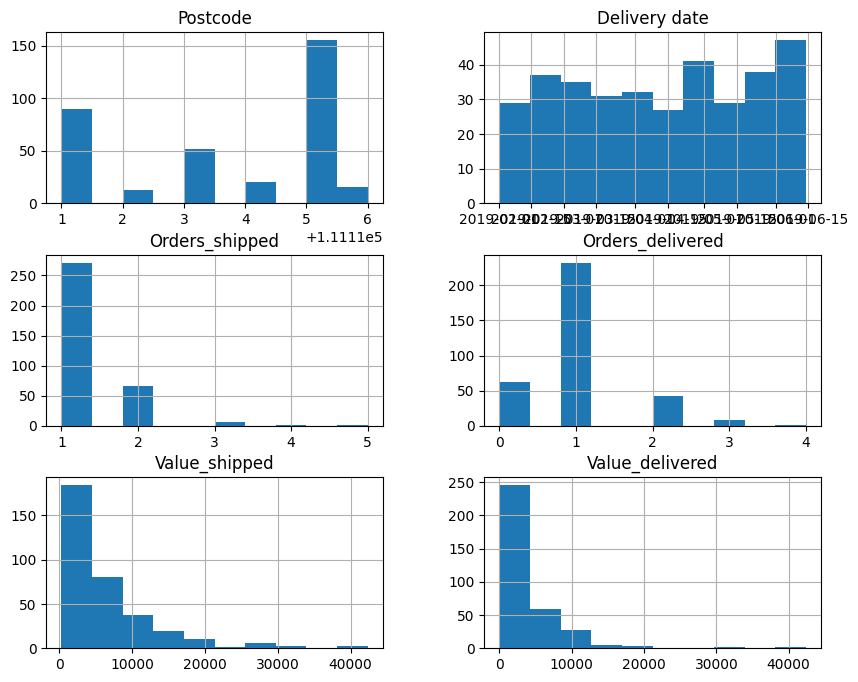

In [606]:
# для общего обзора данных строим гистограммы по всему датасету
df.hist(figsize=(10,8))  # вызываю метод hist
plt.show()

150 наблюдений в 5 районе города, на далее идет 1 район с количеством наблюдений около 90. Меньше всего заказов во 2 и 6 районах.

По датам заказы распределены примерно одинаково.

Чаще всего в отправленном заказе 1 товар. Максимальное количество товаров в заказе - 5.

Чаще покупают 1 товар, есть ситуации, когда товар не выкупают.

Чаще всего стоимость отправленного и доставленного заказа не превышает 5000 ден.ед.

Эти первоначальные выводы на основании гистограмм по датасету.



**Вывод**:

- Предварительно можно утверждать, что данных достаточно для анализа.

- Пропусков в данных нет.

- Не видно каких-то аномальных значений в колонках, например отрицательных чисел.

- Приступим к предобработке.

## Предобработка данных

Стиль заголовков

In [607]:
df.columns  # просмотр названий колонок

Index(['Postcode', 'Delivery date', 'Orders_shipped', 'Orders_delivered',
       'Value_shipped', 'Value_delivered'],
      dtype='object')

In [608]:
# новые названия колонок
new_columns = ['postcode', 'delivery_date', 'orders_shipped', 'orders_delivered', 'value_shipped',\
               'value_delivered']

# замена названий колонок
df.columns = new_columns


In [609]:
display(f'Количество явных дубликатов в данных: {df.duplicated().sum()}')

'Количество явных дубликатов в данных: 0'

In [610]:
#  изучим уникальные значения
columns = df.columns
for col in columns:
    unique_values = df[col].unique()
    sorted_values = pd.Series(unique_values).sort_values().values
    print('-' * 25)
    print(col, sorted_values)

-------------------------
postcode [111111 111112 111113 111114 111115 111116]
-------------------------
delivery_date ['2019-02-01T06:00:00.000000000' '2019-02-01T08:51:59.616000000'
 '2019-02-02T06:15:00.288000000' '2019-02-02T08:21:00.288000000'
 '2019-02-03T06:06:59.904000000' '2019-02-04T05:53:00.096000000'
 '2019-02-04T08:10:59.808000000' '2019-02-04T22:14:00.096000000'
 '2019-02-05T05:46:00.192000000' '2019-02-05T08:23:00.384000000'
 '2019-02-07T06:04:59.808000000' '2019-02-07T08:14:00.384000000'
 '2019-02-07T20:12:00.288000000' '2019-02-08T05:42:59.616000000'
 '2019-02-08T21:08:00.384000000' '2019-02-08T22:00:00.288000000'
 '2019-02-09T06:31:00.192000000' '2019-02-10T05:06:59.616000000'
 '2019-02-11T10:05:00.096000000' '2019-02-11T22:43:00.192000000'
 '2019-02-12T05:41:00.384000000' '2019-02-12T08:15:00.000000000'
 '2019-02-13T23:17:59.712000000' '2019-02-14T06:08:00.384000000'
 '2019-02-14T08:21:00.288000000' '2019-02-14T23:15:00.000000000'
 '2019-02-15T06:09:59.616000000' '20

Данные в датасете выгружены с 01 февраля 2019 г. по 13 июня 2019 г.

Минимальная стоимость отправленного заказа - 291.66 ден.ед., максимальная - 42365.83 ден.ед.

Минимальная стоимость доставленного заказа - 0 руб., максимальная - 42365.83 ден.ед.

### Добавление колонок

Добавим в датасет колонку с долей выкупа каждого заказа `proportion_purch`

In [611]:
df['proportion_purch'] = df['orders_delivered'] / df['orders_shipped']


Выделим месяц в дате:

In [612]:
df['delivery_date'] = pd.to_datetime(df['delivery_date'])
df['month'] = df['delivery_date'].dt.month
# Создаем словарь с названием дня недели
name_month = {
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь'
}
# Применяем метод map() к столбику 'month'
df['month'] = df['month'].map(name_month)

In [613]:
# заменим цифры в столбце `postcode` на понятные названия
postcode_mapping = {
    111111: 'район 1',
    111112: 'район 2',
    111113: 'район 3',
    111114: 'район 4',
    111115: 'район 5',
    111116: 'район 6'
}

# Замена значений в столбце postcode
df['postcode'] = df['postcode'].replace(postcode_mapping)

### Основная статистическая информация о датафрейме

С помощью метода describe() посмотрим основную статистическую информацию.Метод отражает основные статистические характеристики для каждого столбца. Нам полезно посмотреть разброс значений по каждому столбику, чтобы оценить наличие аномальных значений.

In [614]:
df.describe([0.25, 0.75, 0.95, 0.99])

,orders_shipped,orders_delivered,value_shipped,value_delivered,proportion_purch
count,346.00,346.00,346.00,346.00,346.00
mean,1.25,0.99,6588.92,4165.06,0.79
std,0.53,0.65,6837.46,5364.12,0.39
min,1.00,0.00,291.67,0.00,0.00
25%,1.00,1.00,2334.79,1249.17,1.00
50%,1.00,1.00,4210.83,2579.58,1.00
75%,1.00,1.00,8355.42,4829.17,1.00
95%,2.00,2.00,18505.67,12206.53,1.00
99%,3.00,3.00,32779.08,28276.67,1.00
max,5.00,4.00,42365.83,42365.83,1.00


Половина отправленных заказов имеют стоимость до 4210.83 ден.ед.

Половина доставленных - до 2579.58 ден.ед.

Посмотрим боксплот:

Посмотрим отправленные заказы дороже 18505.67 ден.ед. и доставленные заказы дороже 12206.53:

In [615]:
max_ord = df['value_shipped'].quantile(0.95)
df.query('value_shipped > @max_ord')

,postcode,delivery_date,orders_shipped,orders_delivered,value_shipped,value_delivered,proportion_purch,month
1,район 1,2019-02-04 22:14:00.096,1,0,21600.00,0.00,0.00,Февраль
12,район 1,2019-02-20 22:56:00.384,1,1,28055.83,1149.17,1.00,Февраль
14,район 1,2019-02-26 22:47:00.384,1,1,18975.00,1233.33,1.00,Февраль
25,район 1,2019-03-15 22:27:00.288,2,1,28889.17,3331.67,0.50,Март
61,район 1,2019-05-12 22:54:00.288,1,1,29230.91,1692.73,1.00,Май
65,район 1,2019-05-16 13:00:59.904,1,0,19105.83,0.00,0.00,Май
76,район 1,2019-05-31 23:15:59.616,1,1,18528.26,3300.00,1.00,Май
82,район 1,2019-06-06 23:19:59.808,2,1,29506.25,2781.25,0.50,Июнь
85,район 1,2019-06-09 19:34:00.192,1,1,31863.33,3665.00,1.00,Июнь
87,район 1,2019-06-11 21:56:00.096,1,1,41535.00,4165.83,1.00,Июнь


In [616]:
max_ord = df['value_delivered'].quantile(0.95)
df.query('value_delivered > @max_ord')

,postcode,delivery_date,orders_shipped,orders_delivered,value_shipped,value_delivered,proportion_purch,month
81,район 1,2019-06-06 18:09:00.000,1,0,15383.33,15383.33,0.00,Июнь
86,район 1,2019-06-10 17:35:59.712,1,0,17455.00,17455.00,0.00,Июнь
118,район 3,2019-03-31 09:00:00.000,1,1,33528.33,33528.33,1.00,Март
152,район 3,2019-06-10 08:35:00.096,1,1,17889.17,17889.17,1.00,Июнь
160,район 4,2019-03-14 06:09:59.616,1,1,30166.67,30166.67,1.00,Март
172,район 4,2019-05-27 08:14:00.384,1,0,42365.83,42365.83,0.00,Май
180,район 5,2019-02-05 08:23:00.384,1,1,21098.83,21098.83,1.00,Февраль
196,район 5,2019-02-17 09:22:00.192,2,2,12595.42,12595.42,1.00,Февраль
218,район 5,2019-03-02 05:46:59.808,1,1,12221.67,12221.67,1.00,Март
231,район 5,2019-03-12 05:50:00.384,1,1,25966.67,25966.67,1.00,Март


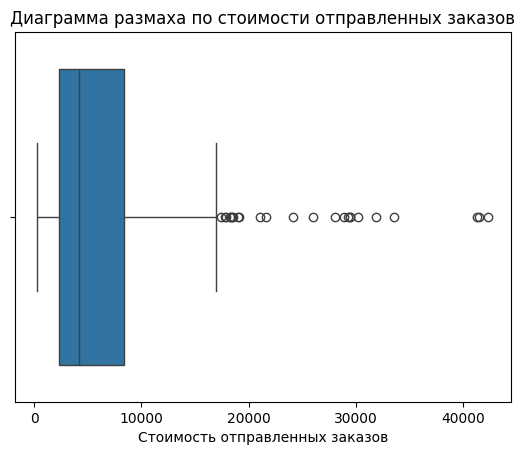

In [617]:
sns.boxplot(x=df['value_shipped'])
plt.xlabel('Стоимость отправленных заказов')
plt.title('Диаграмма размаха по стоимости отправленных заказов')
plt.show()

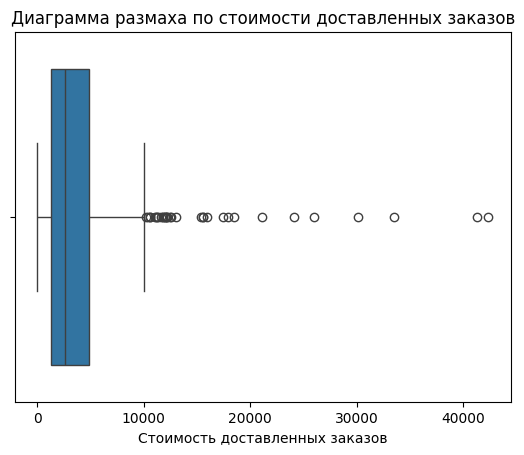

In [618]:
sns.boxplot(x=df['value_delivered'])
plt.xlabel('Стоимость доставленных заказов')
plt.title('Диаграмма размаха по стоимости доставленных заказов')
plt.show()

За пределами верхнего уса на обоих графиках есть значения, принято решение срезать 1% данных для более точного анализа, так как самые дорогие заказы похожи на выбросы. Однако не буем срезать все значения за пределами уса, так как наблюдения плотно располодены около друг друга, похоже на какую-то тенденцию.

In [619]:
# Вычисление 99-го перцентиля и очистка данных по 99-му перцентилю
percentile_99 = df['value_shipped'].quantile(0.99)
df_cleaned = df[df['value_shipped'] < percentile_99]

percentile_99 = df['value_delivered'].quantile(0.99)
df_cleaned = df[df['value_delivered'] < percentile_99]


In [620]:
df_cleaned.groupby('postcode')['value_shipped'].describe()

,count,mean,std,min,25%,50%,75%,max
postcode,,,,,,,,
район 1,90.00,8395.12,8265.03,291.67,2757.29,5730.63,12842.88,41535.00
район 2,13.00,5797.76,4966.64,991.67,2221.45,3578.88,8982.50,18365.67
район 3,51.00,5556.46,5470.87,449.17,1794.58,3885.00,7664.17,29480.83
район 4,18.00,4057.68,3346.19,329.17,1899.38,2910.00,4539.38,12771.67
район 5,154.00,5714.82,4732.15,499.17,2457.18,4046.33,7821.15,25966.67
район 6,16.00,4058.54,3462.66,1499.17,2242.50,2976.67,4128.54,15405.83


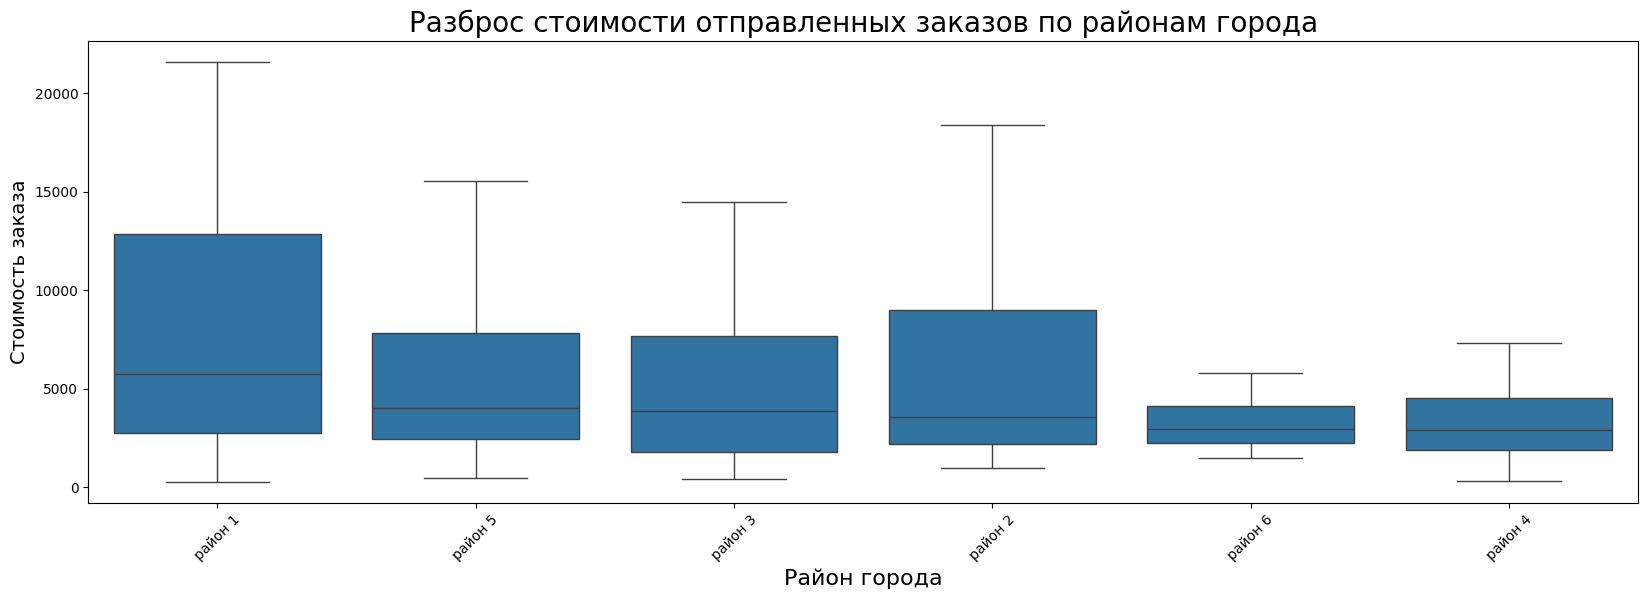

In [621]:
fig = plt.figure(figsize = (20, 6))
medians = df_cleaned.groupby('postcode')['value_shipped'].median().sort_values(ascending=False).index
sns.boxplot(x=df_cleaned['postcode'], y=df_cleaned['value_shipped'],showfliers = False, order=medians)
plt.title(label = 'Разброс стоимости отправленных заказов по районам города', fontsize = 20)
plt.ylabel('Стоимость заказа',  fontsize = 14)
plt.xlabel( 'Район города', size = 16)
plt.xticks(fontsize = 10, rotation = 45)
plt.show()

По графику распределения стоимости отправленных заказов по районам города видно, что медианная стоимость выше в 1 районе - 5730.63 ден.ед. Половина всех отправленных заказов находится в диапозоне от 2757.29 до 12842.88 ден.ед.

Медианная стоимость заказов в 5 районе - 4081.82 ден.ед. Половина всех заказов оценивается в диапозоне от 2462.69 до 7832.71 ден.ед.

Самые недорогие заказы как правило в 6 районе.



In [622]:
df_cleaned.groupby('postcode')['value_delivered'].describe()

,count,mean,std,min,25%,50%,75%,max
postcode,,,,,,,,
район 1,90.00,2417.99,2794.54,0.00,604.62,1742.20,3323.75,17455.00
район 2,13.00,2479.63,1971.90,0.00,1249.17,2221.45,3456.45,6537.73
район 3,51.00,3330.10,3303.59,0.00,1149.17,2332.50,4435.80,17889.17
район 4,18.00,2390.68,2814.99,0.00,0.00,1767.08,3515.04,10398.33
район 5,154.00,5167.39,4755.44,0.00,1965.00,3749.17,7400.52,25966.67
район 6,16.00,2201.04,1739.21,0.00,1124.38,2152.50,2945.00,5787.50


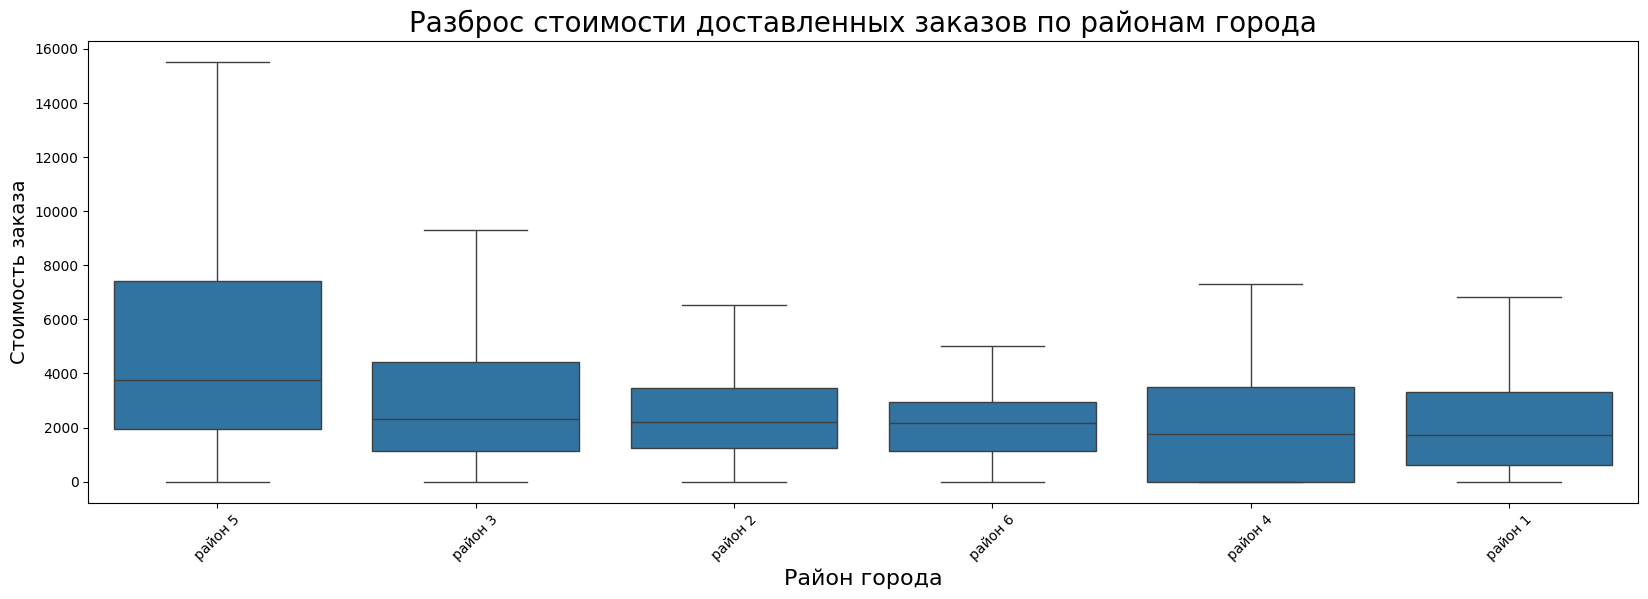

In [623]:
fig = plt.figure(figsize = (20, 6))
medians = df_cleaned.groupby('postcode')['value_delivered'].median().sort_values(ascending=False).index
sns.boxplot(x=df_cleaned['postcode'], y=df_cleaned['value_delivered'],showfliers = False, order=medians)
plt.title(label = 'Разброс стоимости доставленных заказов по районам города', fontsize = 20)
plt.ylabel('Стоимость заказа',  fontsize = 14)
plt.xlabel( 'Район города', size = 16)
plt.xticks(fontsize = 10, rotation = 45)
plt.show()

А вот по выкупленных заказам ситуация другая:

В лидерах район 5: медианная стоимость доставленных товаров -3749.17 ден.ед.


In [624]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 345
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   postcode          342 non-null    object        
 1   delivery_date     342 non-null    datetime64[ns]
 2   orders_shipped    342 non-null    int64         
 3   orders_delivered  342 non-null    int64         
 4   value_shipped     342 non-null    float64       
 5   value_delivered   342 non-null    float64       
 6   proportion_purch  342 non-null    float64       
 7   month             342 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 24.0+ KB


**Вывод**:

- Данные с 01 февраля по 13 июня 2019 г.
- В очищенном датасете 342 наблюдения.
- Выделили столбцы с долей выкупа и месяцем.
- Изучили основную статистическую информацию.
- Самая высокая медианная стоимость отправленных заказов в 1 районе - 5730.63 ден.ед. Половина всех отправленных заказов находится в диапозоне от 2757.29 до 12842.88 ден.ед., далее идет 5 район - 4081.82 ден.ед.
- Самая высокая медианная стоимость доставленных заказов в 5 районе -3749.17 ден.ед.

## Исследовательский анализ данных

#### Анализ количества заказов по районам

In [625]:
ord_count = df_cleaned.groupby('postcode').agg({'orders_shipped':'count', 'proportion_purch':'mean'}) \
                      .sort_values(by='orders_shipped', ascending=False).reset_index()

ord_count


,postcode,orders_shipped,proportion_purch
0,район 5,154,0.87
1,район 1,90,0.73
2,район 3,51,0.84
3,район 4,18,0.61
4,район 6,16,0.44
5,район 2,13,0.70


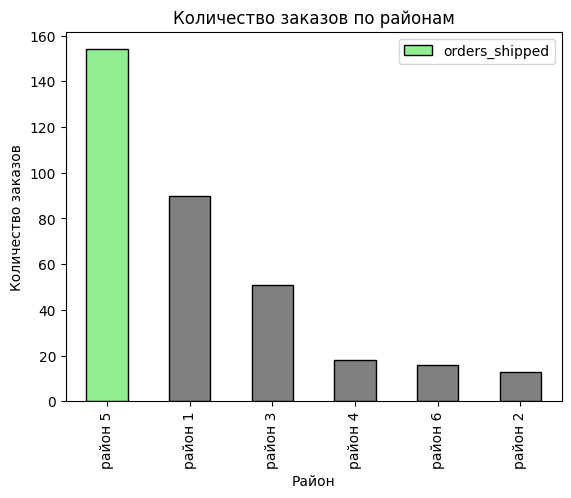

In [626]:
colors = ['lightgreen' if x == ord_count['orders_shipped'].max() else 'gray' for x in ord_count['orders_shipped']]
ord_count.plot(x='postcode', y='orders_shipped', kind='bar', color=colors, edgecolor='black')

# Настройка осей и заголовка
plt.xlabel('Район')
plt.ylabel('Количество заказов')
plt.title('Количество заказов по районам')

# Отображение гистограммы
plt.show()

Топ-3 района по количеству заказов:  5 район - 154 шт., 1 район - 90 шт. и 3 район - 51 шт.

Причем средняя доля выкупа  выше в 5 районе (0.87), 87 % товаров выкупают, далее идет 3 район - 84 % выкупленных товаров и 1 район - 73% выкуп.


In [627]:
df.columns

Index(['postcode', 'delivery_date', 'orders_shipped', 'orders_delivered',
       'value_shipped', 'value_delivered', 'proportion_purch', 'month'],
      dtype='object')

#### Анализ стоимости заказов по районам

In [628]:
cost_count = df_cleaned.groupby('postcode').agg({'value_shipped':'sum','value_delivered':'sum'}) \
                      .sort_values(by='value_shipped', ascending=False).reset_index()

cost_count['доля_отп'] = cost_count['value_shipped'] / cost_count['value_shipped'].sum()
cost_count['доля_выкуп'] = cost_count['value_delivered'] / cost_count['value_delivered'].sum()
cost_count


,postcode,value_shipped,value_delivered,доля_отп,доля_выкуп
0,район 5,880082.71,795777.86,0.41,0.62
1,район 1,755560.53,217618.83,0.35,0.17
2,район 3,283379.51,169835.34,0.13,0.13
3,район 2,75370.85,32235.13,0.04,0.02
4,район 4,73038.32,43032.18,0.03,0.03
5,район 6,64936.67,35216.67,0.03,0.03


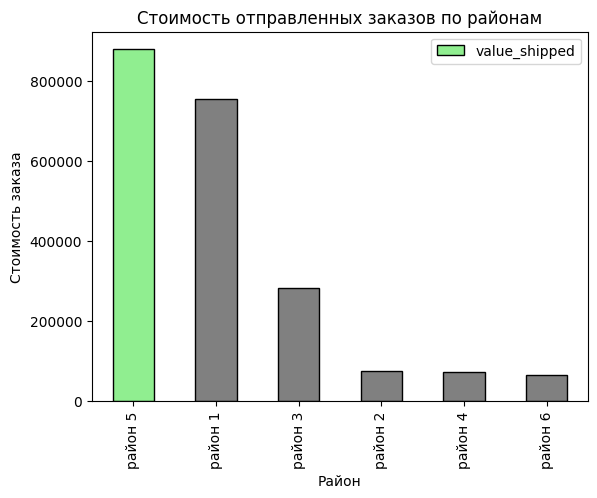

In [629]:
colors = ['lightgreen' if x == cost_count['value_shipped'].max() else 'gray' for x in cost_count['value_shipped']]
cost_count.plot(x='postcode', y='value_shipped', kind='bar', color=colors, edgecolor='black')
plt.xlabel('Район')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость отправленных заказов по районам')
plt.show()

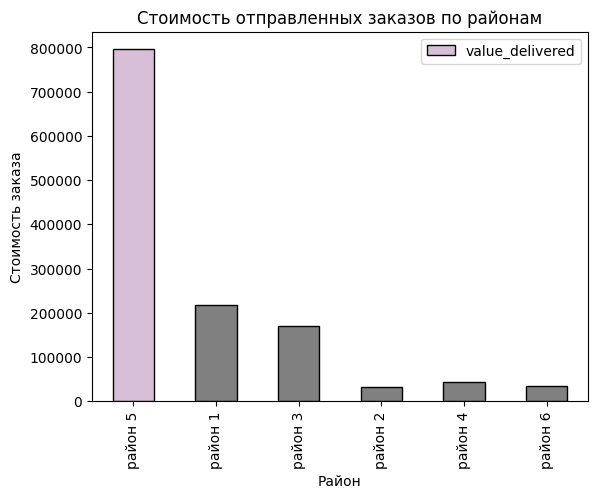

In [630]:
colors = ['#D8BFD8' if x == cost_count['value_delivered'].max() else 'gray' for x in cost_count['value_delivered']]
cost_count.plot(x='postcode', y='value_delivered', kind='bar', color=colors, edgecolor='black')
plt.xlabel('Район')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость отправленных заказов по районам')
plt.show()

По стоимости отправленных заказов лидерует 5 район - 880082.71 ден.ед., далее 1 район - 755560.53 ден.ед..
Остальные районы заказали на сумму менее, чем 300000 ден.ед.

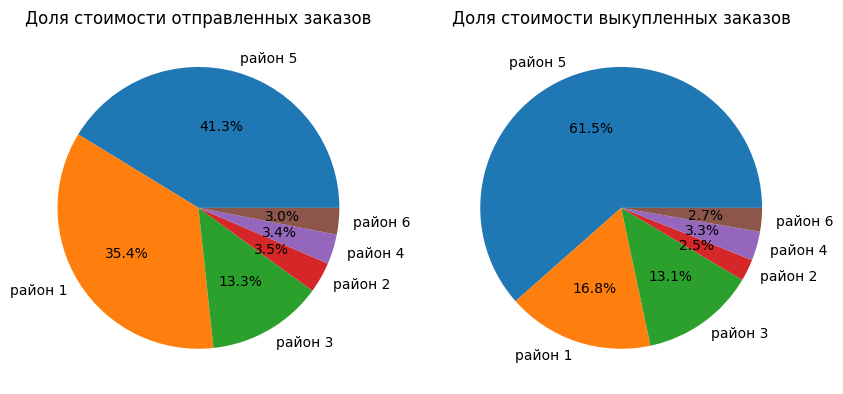

In [631]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(cost_count['value_shipped'], labels=cost_count['postcode'], autopct='%1.1f%%')
ax1.set_title('Доля стоимости отправленных заказов')

ax2.pie(cost_count['value_delivered'], labels=cost_count['postcode'], autopct='%1.1f%%')
ax2.set_title('Доля стоимости выкупленных заказов')

plt.show()

По стоимости отправленных заказов район 5 и район 1 занимают 41.3% и 35.4% от общей стоимости заказов.

А вот по доставленным заказам район 5 показывает 61.5%, район 1 значительно меньше - 16.8%.

В 3 районе доля отправленных и доставленных заказов 13.3% и 13,1% соответственно.

В 5 районе заказали на сумму - 880082.71, выкупили на сумму - 795777.86.

В 1 районе большой провал: заказов на сумму - 755560.53, а выкупили на сумму 217618.83.



#### Анализ количества и стоимости заказов по дате

Посмотрим изменение выручки магазина по месяцам за весь период. По дням получается очень шумный график, поэтому создадим столбец year_month и посмотрим по нему.

In [632]:
df_cleaned['month_year'] = df_cleaned['delivery_date'].dt.strftime('%Y-%m')

<ipython-input-632-3b64f5232350>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['month_year'] = df_cleaned['delivery_date'].dt.strftime('%Y-%m')


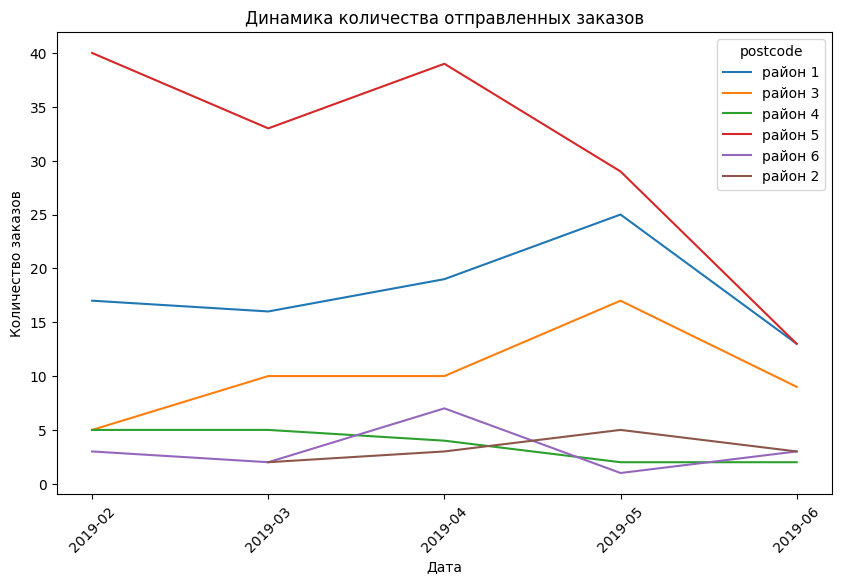

In [633]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='orders_shipped',
             data=df_cleaned.groupby(['month_year','postcode']).agg({'orders_shipped':'count'}),
             hue='postcode'
             )
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Динамика количества отправленных заказов')
plt.xticks(rotation=45)
plt.show()

Надо учесть, что за июнь данные неполные, поэтому все линии падают в июне. Однако видно, что лидер по количеству заказов - район 5  сравнялся с районом 1 за первую половину июня.

Данные за июнь неполные, уберем их из графика,посмотрим что будет без июня:

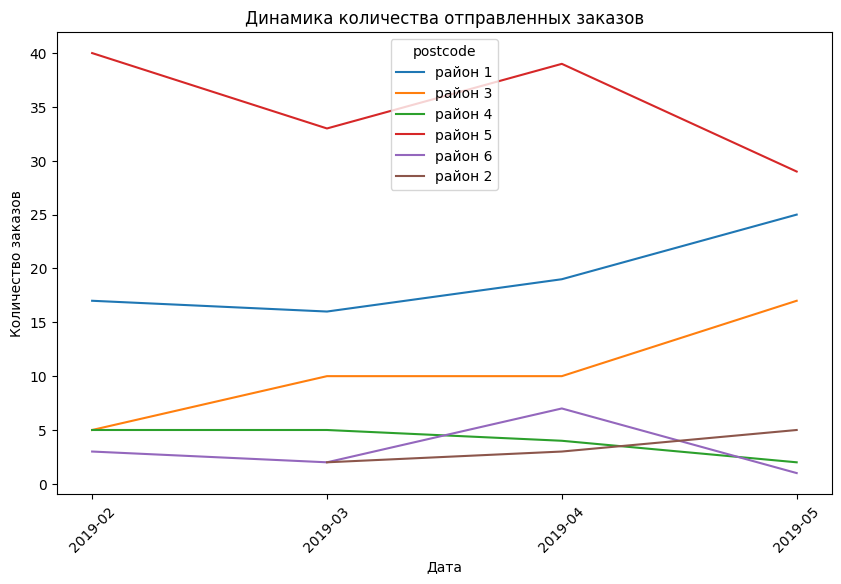

In [634]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='orders_shipped',
             data=df_cleaned.query('month != "Июнь"').groupby(['month_year','postcode']).agg({'orders_shipped':'count'}),
             hue='postcode'
             )
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Динамика количества отправленных заказов')
plt.xticks(rotation=45)
plt.show()

В районе 5 количество заказов с течением времени падает, а вот районы 1 и 3 имеют восходящий тренд.

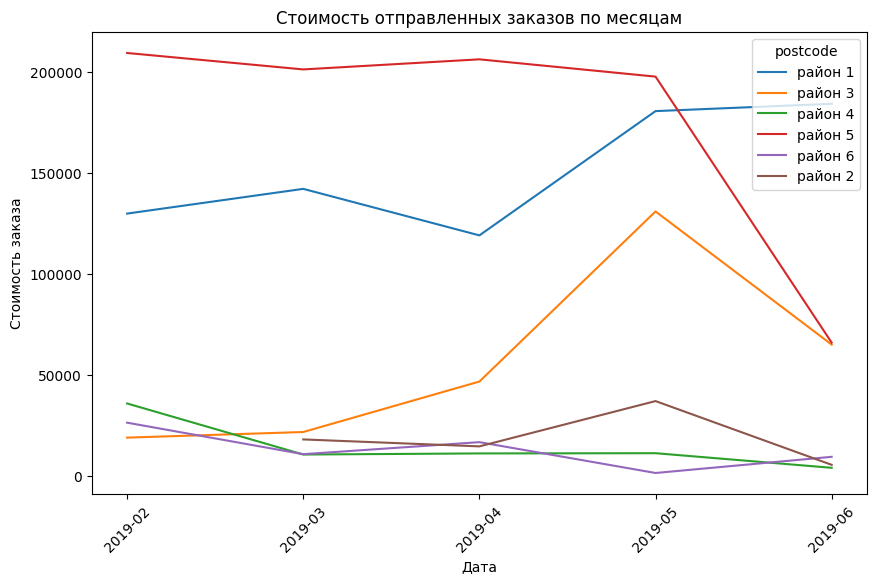

In [635]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='value_shipped',
             data=df_cleaned.groupby(['month_year','postcode']).agg({'value_shipped':'sum'}),
             hue='postcode'
             )
plt.xlabel('Дата')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость отправленных заказов по месяцам')
plt.xticks(rotation=45)
plt.show()

Посмотрим стоимость выкупленных заказов с февраля до мая, так как июньские заказы могут быть еще не доставлены.

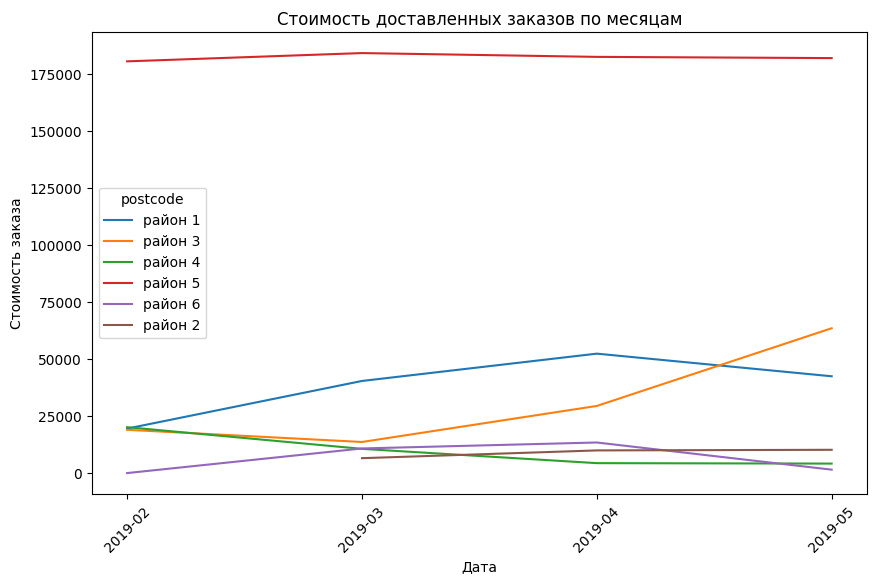

In [636]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='value_delivered',
             data=df_cleaned.query('month != "Июнь"').groupby(['month_year','postcode']).agg({'value_delivered':'sum'}),
             hue='postcode'
             )
plt.xlabel('Дата')
plt.ylabel('Стоимость заказа')
plt.title('Стоимость доставленных заказов по месяцам')
plt.xticks(rotation=45)
plt.show()

Стоимость отправленных заказов по месяцам до июня была выше в районе 5, однако в июне сравнялась с районом 3. В  лидеры вышел район 1, но как мы помним, там маленький выкуп.

Больше всего денег приносил район 5 на протяжении февраля-мая, там выкуп на стабильно высокую сумму, район 3 обогнал район 1 по стомости выкупденных заказов. В районе 3 высокий процент выкупа.

In [637]:
df.columns

Index(['postcode', 'delivery_date', 'orders_shipped', 'orders_delivered',
       'value_shipped', 'value_delivered', 'proportion_purch', 'month'],
      dtype='object')

### **Вывод**:

- Для определения района города, в который компания должна расширить зону доставки интернет-заказов в первую очередь,  чтобы максимизировать количество заказов и увеличить общую прибыль компании мы провели анализ данных.

- Исследование  включало анализ данных о заказах в районах города, включая количество заказов, выручку,  процент отказов.


- Топ-3 района по количеству заказов: 5 район - 154 шт., 1 район - 90 шт. и 3 район - 51 шт.  Стоит отметить также, что районы 1 и 3 имеют восходящий тренд, каждый месяц количество заказов растет.

- Средний процент выкупа выше в 5 районе 87%, , далее идет 3 район - 84 % выкупленных товаров и 1 район - 73%.

- По стоимости отправленных заказов лидерует 5 район - 880082.71 ден.ед.(41.3%), далее 1 район - 755560.53 ден.ед.(35.4%). Остальные районы заказали на сумму менее, чем 300000 ден.ед.

- Однако,  район 3 обогнал в конце периода район 1 по стомости выкупленных заказов. В районе 3 высокий процент выкупа.

- По доставленным заказам район 5 показывает 61.5%, район 1 значительно меньше - 16.8%.

- В 3 районе доля отправленных и доставленных заказов 13.3% и 13,1% соответственно.

- В 1 районе большой провал: заказов на сумму - 755560.53, а выкупили на сумму 217618.83.




### **Рекомендации**:

Расширение зоны доставки можно рассмотерть исходя из целей и стратегий компании.

Если  цель - **улучшение обслуживания и удовлетворение существующих клиентов**, то район с высокими, но стабильными продажами может быть более подходящим.

- Плюсы: Район с высокими продажами может указывать на  установленную базу клиентов и стабильный спрос на товары или услуги. Расширение доставки в таком районе может помочь улучшить обслуживание клиентов и удовлетворить спрос.

- Минусы: В районе с высокими продажами, но без роста, может быть ограниченный потенциал для привлечения новых клиентов и увеличения доходов. Здесь ориентируемся на численность населения в районе.  

 Потенциальный район для расширения доставки при этой стратегии - район 5.

 Стоит отметить, что в районе 1 очень маленький процент выкупа, возможно есть проблемы с доставкой и курьер просто не доезжает до клиентов. Район тоже перспективный для этой стратегии.

Если  цель - **увеличение доходов и привлечение новых клиентов**, то район с растущими продажами может быть предпочтительным.

- Плюсы: Район с растущими продажами может указывать на повышенный спрос. Расширение доставки в такой район может помочь удовлетворить растущий спрос и привлечь новых клиентов. Это может способствовать увеличению доходов и росту бизнеса.

- Минусы: Расширение доставки в районе с растущими продажами может потребовать дополнительных ресурсов и инвестиций.

Потенциал для увеличения объема заказов и где компания может получить наибольшую отдачу от расширения зоны доставки при этой стратегии - район 3.



**Дополнительно стоит проанализировать**:

1. Плотность населения. Если в  районе проживает большое количество людей или плотность населения высокая, это может указывать на потенциальную потребность в расширении доставки в этом районе.

2. Конкуренты. Если в районе мало конкурентов или их нет вовсе, это может представлять возможность для расширения доставки и привлечения новых клиентов.

3. Инфраструктура. Если в районе недостаточно развита инфраструктура или доступность доставки ограничена, это может указывать на потребность в расширении доставки для улучшения обслуживания клиентов.

4. Обратная связь клиентов.  Если часто поступают жалобы или просьбы о расширении доставки, это может указывать на потребность в улучшении обслуживания в этом районе.
